In [1]:
import numpy as np
import os
import re
import pandas as pd
import random
import matplotlib.pyplot as plt
from brokenaxes import brokenaxes

In [2]:
def get_eval_metric(mtcs, file): # 文件中共有多少次eval，以及最后一次eval的metric值
    i = 0
    metric = '\'acc\': '
    target_str = metric + '\d+.?\d+'
    number_str = '\d+.?\d+'
    for line in open(file,"r"):
        if metric in line:
            word = re.findall(target_str, line)[0]
            mtc = re.findall(number_str, word)[0]
            
            mtcs.append(mtc)
            i = i + 1
    return i, mtcs 

def insert_10(left, right):
    l = [left + 1]
    for i in range(left, right):
        if (i - left -1) % 10 == 0 and i != left + 1:
            l.append(i)
    l.append(right)
    return l

def merge_stack(lists):
    for i in range(len(lists)):
        merged_l = []
        l = lists[i]
        for a in l:
            for b in a:
                merged_l.append(b)
        lists[i] = merged_l
    return lists

def cut(x,y,upper_bound_acc):
    x = np.array(x) / 3600 # convert second to hour
    threshold = 0
    delete_y = [t for t in y if t > upper_bound_acc]
    if len(delete_y) > 0:
        if isinstance(y, list):
            threshold = y.index(delete_y[0])
        else:
            threshold = y.tolist().index(delete_y[0])
    else:
        threshold = len(y)
    y = y[:threshold]
    x = x[:threshold]
    return x,y
            
def sum_duration(depth, width, idx, tmp, time, type = "Dyna-A-Freeze", slow_down = 1):
    batch_num = 20
    bw = 1
    latency_tx2_baseline = np.array([0.5325, 0.612, 0.696, 0.791, 0.883, 0.9713, 1.064, 1.156, 1.2465, 1.33, 1.419, 1.51, 1.7]) * slow_down / 4  
    latency_tx2_cached = np.array([0.02, 0.09, 0.18, 0.27, 0.36, 0.45, 0.54, 0.63, 0.72, 0.81, 0.90, 0.99, 1.08]) * slow_down / 4
    comm_bert = np.array([0.6, 7.7, 14.8, 21.9, 29.0, 36.0, 43.1, 50.2, 57.3, 64.4, 71.5, 78.6, 109.5]) * 4 / bw# 这里面没有仅仅freeze embedding的数据
    adapter_para = 0.0125 * width / 8
    comm_adapter =np.array([0.02 + i * adapter_para for i in range(0,13)]) * 4 / bw
    
    if type == "BERT" or type == "Freeze":
        latency = latency_tx2_baseline
        comm = comm_bert * 2
    if type == "Q-Freeze": # 使用误差补偿的方法; Quantize Freeze; TODO:混合精度量化
        latency = latency_tx2_baseline
        comm = comm_bert * 2 / 8  # INT4 量化
    if type == "Quantize" : # 使用误差补偿的方法; Quantize Freeze; TODO:混合精度量化
        latency = latency_tx2_baseline
        comm = comm_bert * 2 / 4  # INT8 量化
    if type == "A-Freeze" or type == "Dyna-A-Freeze":
        latency = latency_tx2_cached 
        comm = comm_adapter * 2

    comm_tmp = comm[depth]
    duration = 0
    for i in range(0, idx - tmp):
        comp_tmp = latency[depth] * batch_num
        duration = duration + comp_tmp + comm_tmp
        # print(comp_tmp,comm_tmp)
    if len(time) > 0:
        time.append(duration + time[-1])
    else:
        time.append(duration)
    return time


In [3]:
ft = 60 # font size
lw = 5 # line width
color = ['blue', 'green', '#FF8C00', '#9370DB', 'red','hotpink']
marker = ["o", "v", "s", "^", "D", "o"]

[0, 1, 2]
[[16.963833333333334, 20.579166666666666, 34.13666666666666], [4.918833333333333, 8.534166666666666, 22.091666666666665], [5.620351111111109, 8.89464444444444, 21.173244444444443], [1.418795555555556, 4.693088888888891, 16.9716888888889], [0.37558888888888875, 1.7263444444444447, 6.791677777777774]]


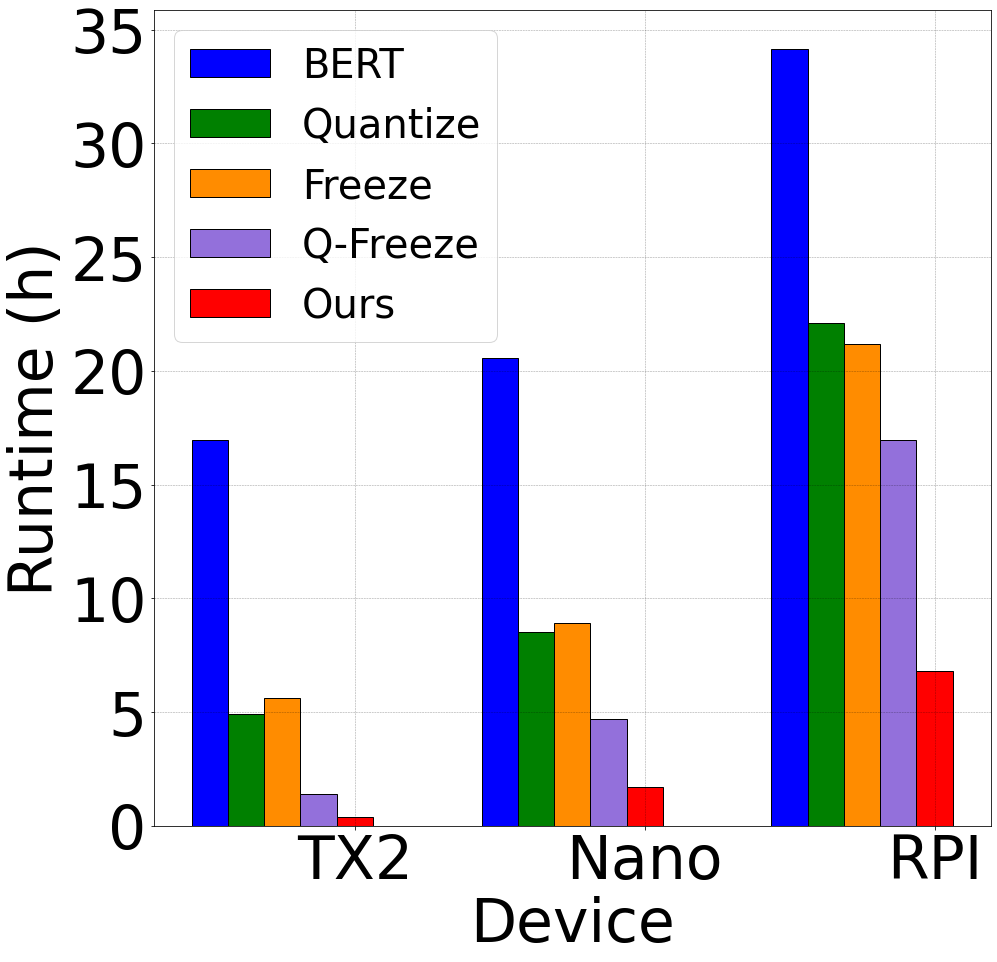

In [18]:
# 无特效
# 20news
root_path = "/Users/cdq/Desktop/opensource/FedFinetuning/"
log_root_path = "data/nice_results/20news-Trail-0-60"
log_file_name = "fednlp_tc_deep_0.log"
file = os.path.join(root_path, log_root_path, log_file_name)


# depth, width, round, metric
dwrm = [[0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3], [8, 8, 8, 16, 16, 16, 24, 32, 32, 32, 40, 48, 48, 48, 56, 64, 64, 64, 64, 64], [-1, 79, 88, 180, 272, 364, 453, 539, 625, 711, 794, 875, 956, 1037, 1115, 1191, 1267, 1343, 1393, 1467], [0, '0.4681359532660648', '0.602761550716941', '0.7422995220392989', '0.7559745087626129', '0.7636749867233139', '0.7684545937334042', '0.7729686670207117', '0.7804036112586299', '0.7838555496548062', '0.7892989909718534', '0.7934147636749868', '0.7954062665958577', '0.7966011683483802', '0.7980616038236856', '0.8005841741901222', '0.8029739776951673', '0.8016463090812533', '0.8020446096654275', '0.8031067445565587']]


flag = ["init"]
trial_num = len(dwrm[0])
for i in range(trial_num-1):
    depth = dwrm[0]
    width = dwrm[1]
    if depth[i+1] > depth[i]: # deeper
        flag.append("deep")
    elif width[i+1] > width[i]: # wider
        flag.append("wide")
    else:
        flag.append("shallow")
dwrm.append(flag)

new_dwrm = [[],[],[],[]]
for i in range(1, trial_num):
    mtcs = [] # metric
    log_file_name = "fednlp_tc_" + dwrm[-1][i] + "_" + str(i-1) + ".log"
    file = os.path.join(root_path, log_root_path, log_file_name)
    count, mtcs = get_eval_metric(mtcs, file)
    new_dwrm[0].append([dwrm[0][i]] * count)
    new_dwrm[1].append([dwrm[1][i]] * count)
    new_dwrm[2].append(insert_10(dwrm[2][i-1], dwrm[2][i]))
    new_dwrm[3].append(mtcs) # mtcs是对的，其它不知道
# print(new_dwrm)

merged_new_dwrm = merge_stack(new_dwrm)
# print(merged_new_dwrm)
# for depth in dwrm:

Origin = os.path.join(root_path,"data/Baseline/20news_uniform_lr=0.1_freeze=_quantize=False_adapter=False_works=5.txt")
Quant = os.path.join(root_path,"data/Baseline/20news_uniform_lr=0.1_freeze=_quantize=True_adapter=False_works=5.txt")
Q_Freeze = os.path.join(root_path,"data/Baseline/20news_uniform_lr=0.1_freeze=e,0,1,2,3,4,5,6,7,8,9_quantize=True_adapter=False_int4.txt")
Freeze = os.path.join(root_path,"data/Baseline/20news_uniform_lr=0.1_freeze=e,0,1,2,3,4,5,6,7,8,9_quantize=False_adapter=False.txt")
def load_baseline(depth, file):
    baseline = []
    for line in open(file,"r"):
        baseline.append(float(line))
    baseline_len = len(baseline)
    baseline_drm = [[depth]*baseline_len, (np.array(range(0, baseline_len))*5).tolist(), baseline]
    return baseline_drm
baseline_origin_drm = load_baseline(12, Origin)
baseline_quant = load_baseline(12, Quant)
baseline_q_freeze_drm = load_baseline(2, Q_Freeze)
baseline_freeze_drm = load_baseline(2, Freeze)



max_acc = 0.8
target_acc = 0.95
max_acc = max_acc * target_acc
bws = [1, 5, 20] # actually is slow down

runtime = [[], [], [], [], []]

for bw in bws:
    time = []
    data = new_dwrm
    tmp = -1 # 记录最后一个访问的idx
    y = [float(i) for i in data[3]]
    for idx in data[2]:
        id = data[2].index(idx)
        d = data[0][id]
        w = data[1][id]
        time = sum_duration(d, w, idx, tmp, time, "Dyna-A-Freeze", bw)
        tmp = idx

    time, y = cut(time, y, max_acc)
    # plt.plot(np.array(time), y, label = "Dyna-A-Freeze")
    # print("Dyna-A-Freeze",time[-1])
    runtime[4].append(time[-1])


    time = []
    tmp = -1 # 记录最后一个访问的idx
    data = baseline_origin_drm
    y = [float(i) for i in baseline_origin_drm[2]]
    for idx in data[1]:
        id = data[1].index(idx)
        d = data[0][id]
        w = 0
        time = sum_duration(d, w, idx, tmp, time, "BERT", bw)
        tmp = idx

    time, y = cut(time, y, max_acc)
    # plt.plot(np.array(time), y, label = "BERT")
    # print("BERT",time[-1])
    runtime[0].append(time[-1])


    time = []
    tmp = -1 # 记录最后一个访问的idx
    data = baseline_origin_drm
    y = [float(i) for i in baseline_origin_drm[2]]
    for idx in data[1]:
        id = data[1].index(idx)
        d = data[0][id]
        w = 0
        time = sum_duration(d, w, idx, tmp, time, "Quantize", bw)
        tmp = idx

    time, y = cut(time, y, max_acc)
    # plt.plot(np.array(time), y, label = "Quant")
    # print("Quant",time[-1])
    runtime[1].append(time[-1])

    time = []
    tmp = -1 # 记录最后一个访问的idx
    data = baseline_freeze_drm
    y = [float(i) for i in baseline_freeze_drm[2]]
    for idx in data[1]:
        id = data[1].index(idx)
        d = data[0][id]
        w = 0
        time = sum_duration(d, w, idx, tmp, time, "Freeze", bw)
        tmp = idx

    time, y = cut(time, y, max_acc)
    # plt.plot(np.array(time), y, label = "Freeze")
    # print("Freeze",time[-1])
    runtime[2].append(time[-1])

    time = []
    tmp = -1 # 记录最后一个访问的idx
    data = baseline_q_freeze_drm
    y = [float(i) for i in baseline_q_freeze_drm[2]]
    for idx in data[1]:
        id = data[1].index(idx)
        d = data[0][id]
        w = 0
        time = sum_duration(d, w, idx, tmp, time, "Q-Freeze", bw)
        tmp = idx

    time, y = cut(time, y, max_acc)
    # plt.plot(np.array(time), y, label = "Q-Freeze")
    # print("Q-Freeze",time[-1])
    runtime[3].append(time[-1])

plt.figure(figsize=(15,15))
# 设置刻度字体大小
# plt.title("Text Classification (20news)",fontsize=ft)
# 设置刻度字体大小
plt.xticks(fontsize=ft)
plt.yticks(fontsize=ft)
plt.xlabel("Device", fontsize=ft)
plt.ylabel("Runtime (h)", fontsize=ft)
plt.grid(color = 'k', linestyle = '--', linewidth = 0.5, alpha=0.4)

type = ["BERT", "Quantize", "Freeze", "Q-Freeze", "Ours"]
x = list(range(3))
print(x)
print(runtime)
total_width, n = 1, 8
width = total_width / n
plt.bar(x, runtime[0], width=width, label=type[0], fc=color[0], edgecolor='black')

for i in range(1,5):
    for j in range(len(x)):
        x[j] = x[j] + width
    plt.bar(x, runtime[i], width=width, label=type[i], fc=color[i], edgecolor='black')
plt.xticks(x, labels = ["TX2", "Nano", "RPI"])
plt.legend(fontsize=40,ncol = 1)
plt.savefig('../figs/eval-performance-device-20news.pdf', bbox_inches="tight")

[0, 1, 2]
[[78.0125, 82.48916666666666, 99.27666666666667], [20.3425, 24.819166666666668, 41.60666666666667], [19.779199999999985, 23.12, 35.648], [2.9807555555555614, 6.089555555555556, 17.747555555555554], [2.034577777777781, 6.750577777777768, 24.4355777777778]]


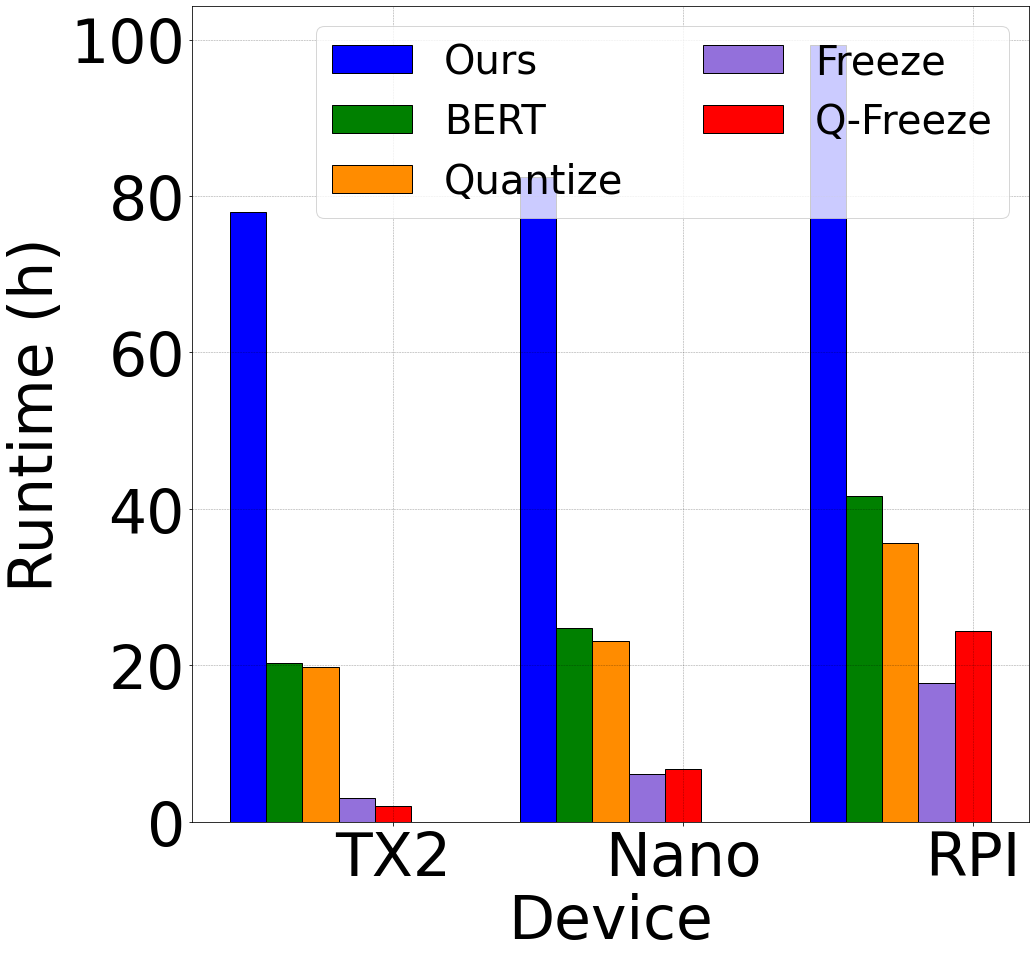

In [10]:
# 无特效
# agnews
root_path = "/Users/cdq/Desktop/opensource/FedFinetuning/"
log_root_path = "data/nice_results/agnews-Trail-0-90"
log_file_name = "fednlp_tc_deep_0.log"
file = os.path.join(root_path, log_root_path, log_file_name)
ft = 60 # font size

# depth, width, round, metric
dwrm = [[0, 0, 0, 2, 2, 2, 3, 3, 3, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6], [8, 16, 16, 16, 24, 24, 24, 24, 24, 24, 32, 32, 40, 40, 40, 48, 48, 48, 56, 64, 64, 72], [-1, 116, 233, 247, 377, 507, 594, 720, 846, 941, 1061, 1157, 1272, 1387, 1502, 1614, 1726, 1819, 1927, 2032, 2137, 2242], [0, '0.7171052631578947', '0.8127631578947369', '0.8092105263157895', '0.8567105263157895', '0.8693421052631579', '0.8747368421052631', '0.8744736842105263', '0.8794736842105263', '0.8806578947368421', '0.8825', '0.886578947368421', '0.891578947368421', '0.8927631578947368', '0.8956578947368421', '0.8992105263157895', '0.8997368421052632', '0.9021052631578947', '0.9031578947368422', '0.9028947368421053', '0.9032894736842105', '0.906578947368421']]


flag = ["init"]
trial_num = len(dwrm[0])
for i in range(trial_num-1):
    depth = dwrm[0]
    width = dwrm[1]
    if depth[i+1] > depth[i]: # deeper
        flag.append("deep")
    elif width[i+1] > width[i]: # wider
        flag.append("wide")
    else:
        flag.append("shallow")
dwrm.append(flag)

new_dwrm = [[],[],[],[]]
for i in range(1, trial_num):
    mtcs = [] # metric
    log_file_name = "fednlp_tc_" + dwrm[-1][i] + "_" + str(i-1) + ".log"
    file = os.path.join(root_path, log_root_path, log_file_name)
    count, mtcs = get_eval_metric(mtcs, file)
    new_dwrm[0].append([dwrm[0][i]] * count)
    new_dwrm[1].append([dwrm[1][i]] * count)
    new_dwrm[2].append(insert_10(dwrm[2][i-1], dwrm[2][i]))
    new_dwrm[3].append(mtcs) # mtcs是对的，其它不知道
# print(new_dwrm)

merged_new_dwrm = merge_stack(new_dwrm)
# print(merged_new_dwrm)
# for depth in dwrm:

Origin = os.path.join(root_path,"data/Baseline/agnews_niid_label_clients=1000_alpha=10.0_lr=0.1_freeze=_quantize=False_adapter=False_length=64.txt")
Quant = os.path.join(root_path,"data/Baseline/agnews_niid_label_clients=1000_alpha=10.0_lr=0.1_freeze=_quantize=True_adapter=False_length=64.txt")
Q_Freeze = os.path.join(root_path,"data/Baseline/agnews_niid_label_clients=1000_alpha=10.0_lr=0.1_freeze=e,0,1,2,3,4,5,6,7,8,9_quantize=True_adapter=False_length=64.txt")
Freeze = os.path.join(root_path,"data/Baseline/agnews_niid_label_clients=1000_alpha=10.0_lr=0.1_freeze=e,0,1,2,3,4,5,6,7,8,9_quantize=False_adapter=False_length=64.txt")
def load_baseline(depth, file):
    baseline = []
    for line in open(file,"r"):
        baseline.append(float(line))
    baseline_len = len(baseline)
    baseline_drm = [[depth]*baseline_len, (np.array(range(0, baseline_len))*5).tolist(), baseline]
    return baseline_drm
baseline_origin_drm = load_baseline(12, Origin)
baseline_quant = load_baseline(12, Quant)
baseline_q_freeze_drm = load_baseline(2, Q_Freeze)
baseline_freeze_drm = load_baseline(2, Freeze)



max_acc = 0.9
target_acc = 1
max_acc = max_acc * target_acc
bws = [1, 5, 20] # actually is slow down

runtime = [[], [], [], [], []]

for bw in bws:
    time = []
    data = new_dwrm
    tmp = -1 # 记录最后一个访问的idx
    y = [float(i) for i in data[3]]
    for idx in data[2]:
        id = data[2].index(idx)
        d = data[0][id]
        w = data[1][id]
        time = sum_duration(d, w, idx, tmp, time, "Dyna-A-Freeze", bw)
        tmp = idx

    time, y = cut(time, y, max_acc)
    # plt.plot(np.array(time), y, label = "Dyna-A-Freeze")
    # print("Dyna-A-Freeze",time[-1])
    runtime[4].append(time[-1])


    time = []
    tmp = -1 # 记录最后一个访问的idx
    data = baseline_origin_drm
    y = [float(i) for i in baseline_origin_drm[2]]
    for idx in data[1]:
        id = data[1].index(idx)
        d = data[0][id]
        w = 0
        time = sum_duration(d, w, idx, tmp, time, "BERT", bw)
        tmp = idx

    time, y = cut(time, y, max_acc)
    # plt.plot(np.array(time), y, label = "BERT")
    # print("BERT",time[-1])
    runtime[0].append(time[-1])


    time = []
    tmp = -1 # 记录最后一个访问的idx
    data = baseline_origin_drm
    y = [float(i) for i in baseline_origin_drm[2]]
    for idx in data[1]:
        id = data[1].index(idx)
        d = data[0][id]
        w = 0
        time = sum_duration(d, w, idx, tmp, time, "Quantize", bw)
        tmp = idx

    time, y = cut(time, y, max_acc)
    # plt.plot(np.array(time), y, label = "Quant")
    # print("Quant",time[-1])
    runtime[1].append(time[-1])

    time = []
    tmp = -1 # 记录最后一个访问的idx
    data = baseline_freeze_drm
    y = [float(i) for i in baseline_freeze_drm[2]]
    for idx in data[1]:
        id = data[1].index(idx)
        d = data[0][id]
        w = 0
        time = sum_duration(d, w, idx, tmp, time, "Freeze", bw)
        tmp = idx

    time, y = cut(time, y, max_acc)
    # plt.plot(np.array(time), y, label = "Freeze")
    # print("Freeze",time[-1])
    runtime[2].append(time[-1])

    time = []
    tmp = -1 # 记录最后一个访问的idx
    data = baseline_q_freeze_drm
    y = [float(i) for i in baseline_q_freeze_drm[2]]
    for idx in data[1]:
        id = data[1].index(idx)
        d = data[0][id]
        w = 0
        time = sum_duration(d, w, idx, tmp, time, "Q-Freeze", bw)
        tmp = idx

    time, y = cut(time, y, max_acc)
    # plt.plot(np.array(time), y, label = "Q-Freeze")
    # print("Q-Freeze",time[-1])
    runtime[3].append(time[-1])

plt.figure(figsize=(15,15))
# 设置刻度字体大小
# plt.title("Text Classification (agnews)",fontsize=ft)
# 设置刻度字体大小
plt.xticks(fontsize=ft)
plt.yticks(fontsize=ft)
plt.xlabel("Device", fontsize=ft)
plt.ylabel("Runtime (h)", fontsize=ft)
plt.grid(color = 'k', linestyle = '--', linewidth = 0.5, alpha=0.4)

type = ["Ours", "BERT", "Quantize", "Freeze", "Q-Freeze"]
x = list(range(3))
print(x)
print(runtime)
total_width, n = 1, 8
width = total_width / n
plt.bar(x, runtime[0], width=width, label=type[0], fc=color[0], edgecolor='black')

for i in range(1,5):
    for j in range(len(x)):
        x[j] = x[j] + width
    plt.bar(x, runtime[i], width=width, label=type[i], fc=color[i], edgecolor='black')
plt.xticks(x, labels = ["TX2", "Nano", "RPI"])

plt.legend(fontsize=40,ncol = 2)
plt.savefig('../figs/eval-performance-device-agnews.pdf', bbox_inches="tight")

[0, 1, 2]
[[61.66930555555555, 64.03986111111111, 72.92944444444444], [15.861805555555556, 18.23236111111111, 27.121944444444445], [26.842533333333353, 28.473999999999997, 34.592000000000006], [4.048450000000004, 5.827694444444445, 12.49986111111111], [0.9495833333333316, 2.8512500000000056, 9.982499999999982]]


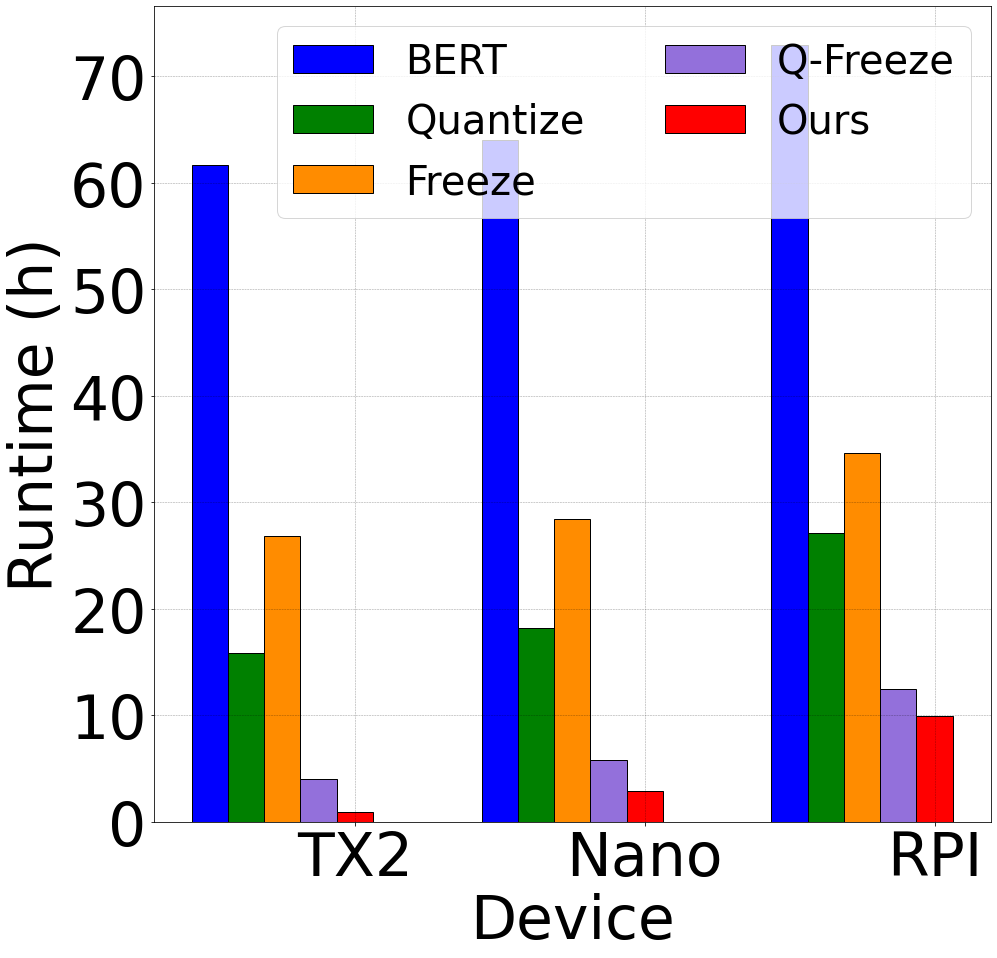

In [4]:
# 无特效
# semeval
root_path = "/Users/cdq/Desktop/opensource/FedFinetuning/"
log_root_path = "data/nice_results/semeval_2010_task8-Trail-0-90"
log_file_name = "semeval_2010_task8-depth-0-freq-90.log"
file = os.path.join(root_path, log_root_path, log_file_name)
ft = 60 # font size

# 
dwrm = [[0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 4, 6, 6, 6, 8, 8, 8, 10, 10, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12], [8, 8, 8, 8, 16, 16, 16, 24, 32, 32, 32, 32, 32, 32, 40, 40, 40, 40, 48, 48, 56, 56, 56, 64, 72, 72, 72, 80, 88, 96, 96, 96, 104, 104, 104, 104, 112, 112, 120, 120], [-1, 158, 317, 476, 635, 655, 848, 1032, 1208, 1384, 1560, 1736, 1825, 1938, 2098, 2258, 2378, 2537, 2689, 2810, 2955, 3076, 3221, 3360, 3499, 3633, 3767, 3906, 4045, 4184, 4304, 4424, 4563, 4680, 4797, 4914, 5053, 5166, 5305, 5414],
[0, '0.242914979757085', '0.26499815973500185', '0.2826647037173353', '0.2937062937062937', '0.31137283768862717', '0.583364004416636', '0.6407802723592197', '0.6676481413323518', '0.68052999631947', '0.6912035333087965', '0.7037173352962827', '0.7059256532940743', '0.7118145012881855', '0.7202797202797203', '0.7280088332719912', '0.7405226352594774', '0.7445712182554288', '0.7523003312476997', '0.7607655502392344', '0.7662863452337136', '0.7769598822230401', '0.7773279352226721', '0.7835848362164152', '0.7865292602134707', '0.7868973132131026', '0.7902097902097902', '0.7924181082075819', '0.7920500552079499', '0.7975708502024291', '0.7957305852042694', '0.7979389032020611', '0.8027235921972764', '0.8008833271991167', '0.8034596981965403', '0.8019874861980125', '0.8005152741994848', '0.8034596981965403', '0.8041958041958042', '0.8078763341921237']]


flag = ["init"]
trial_num = len(dwrm[0])
for i in range(trial_num-1):
    depth = dwrm[0]
    width = dwrm[1]
    if depth[i+1] > depth[i]: # deeper
        flag.append("deep")
    elif width[i+1] > width[i]: # wider
        flag.append("wide")
    else:
        flag.append("shallow")
dwrm.append(flag)

new_dwrm = [[],[],[],[]]
for i in range(1, trial_num):
    mtcs = [] # metric
    log_file_name = "fednlp_tc_" + dwrm[-1][i] + "_" + str(i-1) + ".log"
    file = os.path.join(root_path, log_root_path, log_file_name)
    count, mtcs = get_eval_metric(mtcs, file)
    new_dwrm[0].append([dwrm[0][i]] * count)
    new_dwrm[1].append([dwrm[1][i]] * count)
    new_dwrm[2].append(insert_10(dwrm[2][i-1], dwrm[2][i]))
    new_dwrm[3].append(mtcs) # mtcs是对的，其它不知道
# print(new_dwrm)

merged_new_dwrm = merge_stack(new_dwrm)
# print(merged_new_dwrm)
# for depth in dwrm:

Origin = os.path.join(root_path,"data/Baseline/semeval_2010_task8_niid_label_clients=100_alpha=100_lr=0.1_freeze=_quantize=False_adapter=False_length=64.txt")
Quant = os.path.join(root_path,"data/Baseline/semeval_2010_task8_niid_label_clients=100_alpha=100_lr=0.1_freeze=_quantize=True_adapter=False_length=64.txt")
Q_Freeze = os.path.join(root_path,"data/Baseline/semeval_2010_task8_niid_label_clients=100_alpha=100_lr=0.1_freeze=e,0,1,2,3,4,5_quantize=True_adapter=False_length=64.txt")
Freeze = os.path.join(root_path,"data/Baseline/semeval_2010_task8_niid_label_clients=100_alpha=100_lr=0.1_freeze=e,0,1,2,3,4,5_quantize=False_adapter=False_length=64.txt")
def load_baseline(depth, file):
    baseline = []
    for line in open(file,"r"):
        baseline.append(float(line))
    baseline_len = len(baseline)
    baseline_drm = [[depth]*baseline_len, (np.array(range(0, baseline_len))*5).tolist(), baseline]
    return baseline_drm
baseline_origin_drm = load_baseline(12, Origin)
baseline_quant = load_baseline(12, Quant)
baseline_q_freeze_drm = load_baseline(6, Q_Freeze)
baseline_freeze_drm = load_baseline(6, Freeze)



max_acc = 0.8
target_acc = 0.9
max_acc = max_acc * target_acc
bws = [1, 5, 20] # actually is slow down

runtime = [[], [], [], [], []]

for bw in bws:
    time = []
    data = new_dwrm
    tmp = -1 # 记录最后一个访问的idx
    y = [float(i) for i in data[3]]
    for idx in data[2]:
        id = data[2].index(idx)
        d = data[0][id]
        w = data[1][id]
        time = sum_duration(d, w, idx, tmp, time, "Dyna-A-Freeze", bw)
        tmp = idx

    time, y = cut(time, y, max_acc)
    # plt.plot(np.array(time), y, label = "Dyna-A-Freeze")
    # print("Dyna-A-Freeze",time[-1])
    runtime[4].append(time[-1])


    time = []
    tmp = -1 # 记录最后一个访问的idx
    data = baseline_origin_drm
    y = [float(i) for i in baseline_origin_drm[2]]
    for idx in data[1]:
        id = data[1].index(idx)
        d = data[0][id]
        w = 0
        time = sum_duration(d, w, idx, tmp, time, "BERT", bw)
        tmp = idx

    time, y = cut(time, y, max_acc)
    # plt.plot(np.array(time), y, label = "BERT")
    # print("BERT",time[-1])
    runtime[0].append(time[-1])


    time = []
    tmp = -1 # 记录最后一个访问的idx
    data = baseline_origin_drm
    y = [float(i) for i in baseline_origin_drm[2]]
    for idx in data[1]:
        id = data[1].index(idx)
        d = data[0][id]
        w = 0
        time = sum_duration(d, w, idx, tmp, time, "Quantize", bw)
        tmp = idx

    time, y = cut(time, y, max_acc)
    # plt.plot(np.array(time), y, label = "Quant")
    # print("Quant",time[-1])
    runtime[1].append(time[-1])

    time = []
    tmp = -1 # 记录最后一个访问的idx
    data = baseline_freeze_drm
    y = [float(i) for i in baseline_freeze_drm[2]]
    for idx in data[1]:
        id = data[1].index(idx)
        d = data[0][id]
        w = 0
        time = sum_duration(d, w, idx, tmp, time, "Freeze", bw)
        tmp = idx

    time, y = cut(time, y, max_acc)
    # plt.plot(np.array(time), y, label = "Freeze")
    # print("Freeze",time[-1])
    runtime[2].append(time[-1])

    time = []
    tmp = -1 # 记录最后一个访问的idx
    data = baseline_q_freeze_drm
    y = [float(i) for i in baseline_q_freeze_drm[2]]
    for idx in data[1]:
        id = data[1].index(idx)
        d = data[0][id]
        w = 0
        time = sum_duration(d, w, idx, tmp, time, "Q-Freeze", bw)
        tmp = idx

    time, y = cut(time, y, max_acc)
    # plt.plot(np.array(time), y, label = "Q-Freeze")
    # print("Q-Freeze",time[-1])
    runtime[3].append(time[-1])

plt.figure(figsize=(15,15))
# 设置刻度字体大小
# plt.title("Text Classification (semeval)",fontsize=ft)
# 设置刻度字体大小
plt.xticks(fontsize=ft)
plt.yticks(fontsize=ft)
plt.xlabel("Device", fontsize=ft)
plt.ylabel("Runtime (h)", fontsize=ft)
plt.grid(color = 'k', linestyle = '--', linewidth = 0.5, alpha=0.4)

type = ["BERT", "Quantize", "Freeze", "Q-Freeze", "Ours"]
x = list(range(3))
print(x)
print(runtime)
total_width, n = 1, 8
width = total_width / n
plt.bar(x, runtime[0], width=width, label=type[0], fc=color[0], edgecolor='black')

for i in range(1,5):
    for j in range(len(x)):
        x[j] = x[j] + width
    plt.bar(x, runtime[i], width=width, label=type[i], fc=color[i], edgecolor='black')
plt.xticks(x, labels = ["TX2", "Nano", "RPI"])

plt.legend(fontsize=40,ncol = 2)
plt.savefig('../figs/eval-performance-device-semeval.pdf', bbox_inches="tight")